# Anomaly Detection

The issue with anomaly detection in time series is that an anomaly is not always well-defined. This notebook introduces several techniques native to scalecast that can be used to identify anomalies, but it is ultimately up to the user to determine what is and isn't actually an anomaly.

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats        
from scalecast.Forecaster import Forecaster
from scalecast.AnomalyDetector import AnomalyDetector
from scalecast.SeriesTransformer import SeriesTransformer

In [2]:
sns.set(rc={'figure.figsize':(12,6)})

In [3]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start='1959-01-01',
    end='2022-05-01',
).reset_index()

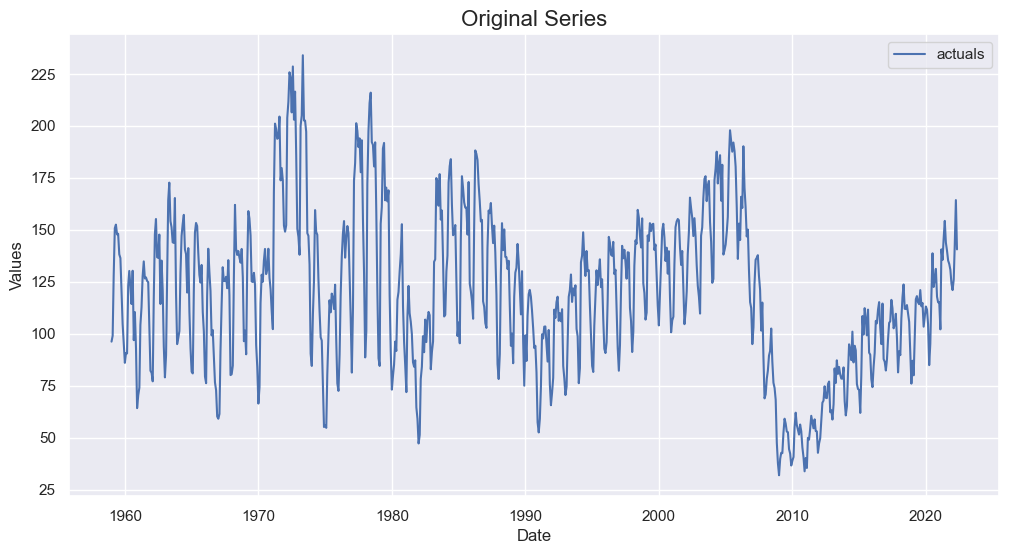

In [4]:
f = Forecaster(
    y=df['HOUSTNSA'],
    current_dates=df['DATE']
)

f.plot()
plt.title('Original Series',size=16)
plt.show()

## Naive Detect

This algorithm functions by decomposing a given series into a trend, seasonal, and residual part testing the residuals' distance from the mean to identify anomalies. It is computationally cheap, but if the series isn't well-explained by the decomposition process, or the residual is not independent and/or not normal, this can be a poor way to identify anomalies.

In [5]:
detector1 = AnomalyDetector(f)

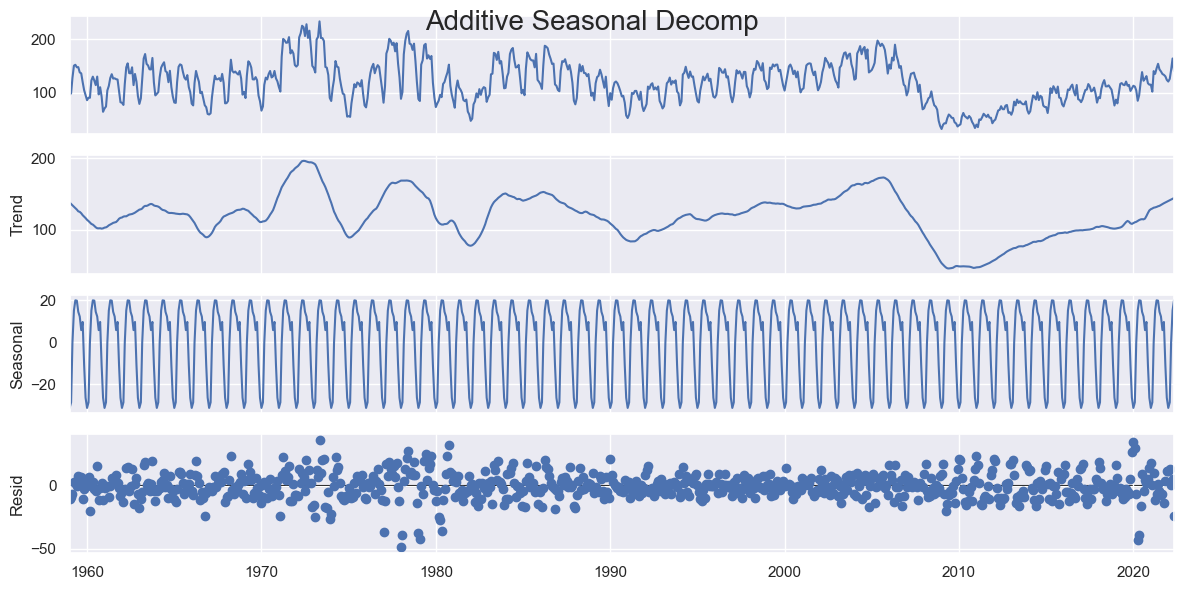

In [6]:
f.seasonal_decompose(extrapolate_trend='freq').plot()
plt.suptitle('Additive Seasonal Decomp',size=20)
plt.show()

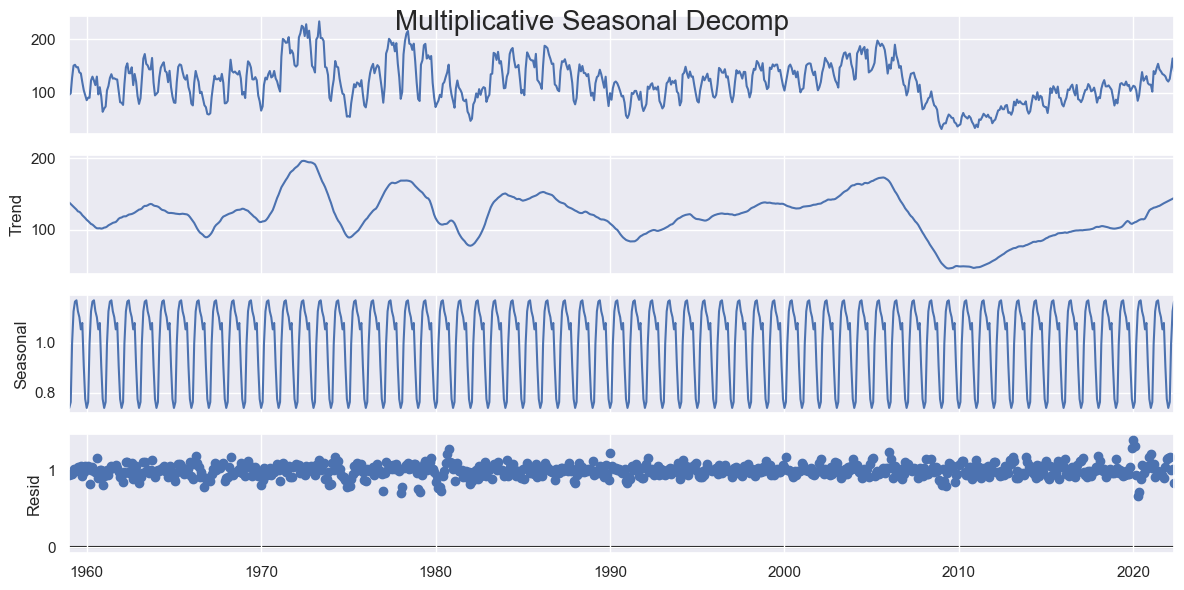

In [7]:
f.seasonal_decompose(
    model='multiplicative',
    extrapolate_trend='freq'
).plot()
plt.suptitle('Multiplicative Seasonal Decomp',size=20)
plt.show()

The key parameters in the function below include the type of decomposition (additive or multiplicative), as well as the confidence level. The higher the confidence level, the fewer anomalies will be detected. The type of decomposition should conform with whichever one creates the most ideal residuals (should be normally abnd randomly distributed, independent, and homoskedastic).

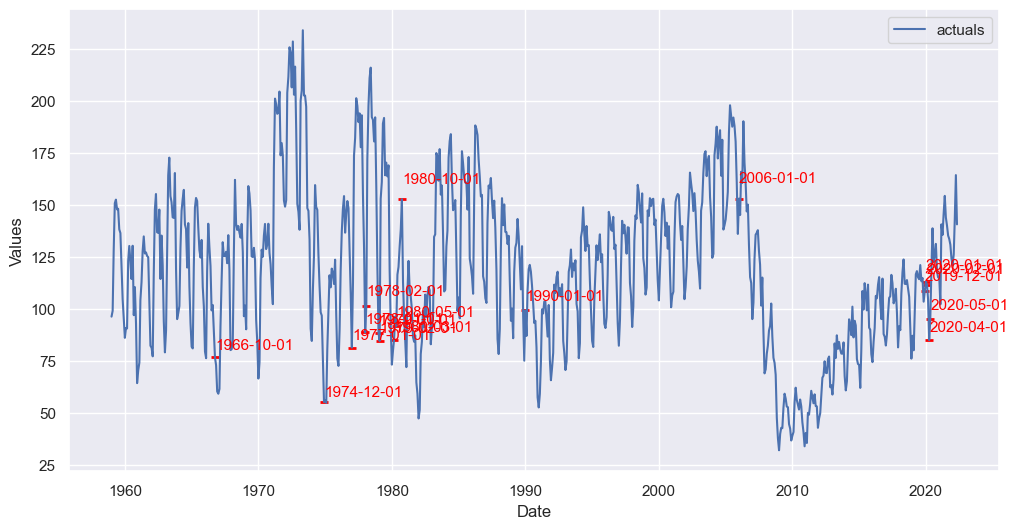

In [8]:
detector1.NaiveDetect(
    extrapolate_trend='freq',
    model='multiplicative',
    cilevel=.99,
)
detector1.plot_anom(label=True)
plt.show()

This method identified many anomalies and perhaps isn't the best method for this series, which exhibits irregular cycles and trends.

## Monte Carlo Detect

This is a Monte Carlo simulated method that produces possible future paths for the data over some time span and uses a confidence interval to evaluate what percent of the time the actual data fell above or below the simulated paths. To make this method work properly, we should transform the distribution so that we can make it as stationary and normally distributed as possible. Therefore, extra care will be taken to prepare the data before applying the method.

To get started, we can transform the dataset so that a log transformation is taken to normalize some of the skew in the dataset, then a seasonal difference of 12 months is applied on the data, then the first difference of the resulting series is applied.

In [9]:
f_transform = f.copy()

transformer = SeriesTransformer(f_transform)

f_transform = transformer.LogTransform()     # log transform
f_transform = transformer.DiffTransform(12)  # seasonally adjust
f_transform = transformer.DiffTransform(1)   # first difference

detector2 = AnomalyDetector(f_transform)

All of these transformations, as well as any models run after the transformations were called, are revertible by calling their reversion counterpart methods in revserse order, demonstrated (by not applied) by the code below:

```python
# how to revert all transformations
f_transform = transformer.DiffRevert(1)
f_transform = transformer.DiffRevert(12)
f_transform = transformer.LogRevert()
```

Now, we can see the resulting series:

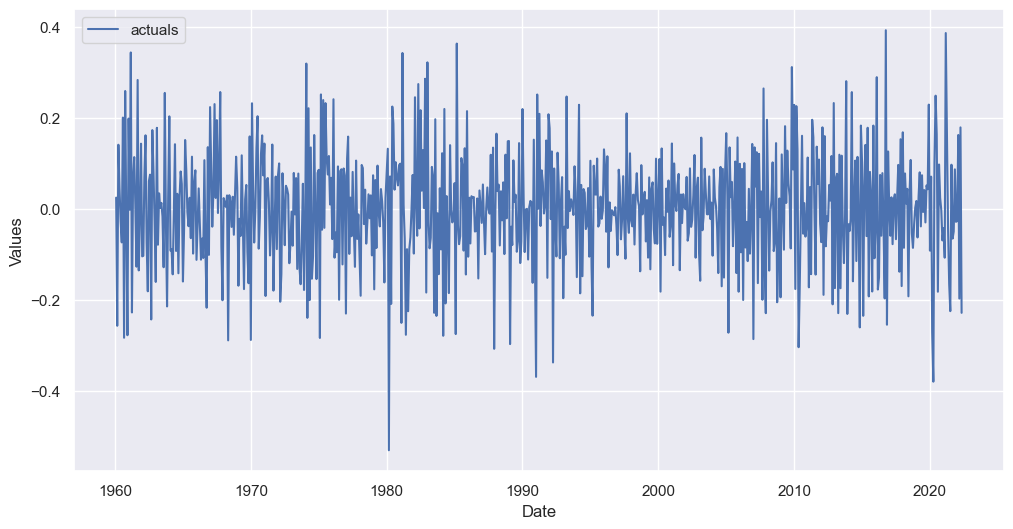

In [10]:
f_transform.plot()
plt.show()

Call a histogram to make sure it looks normal:

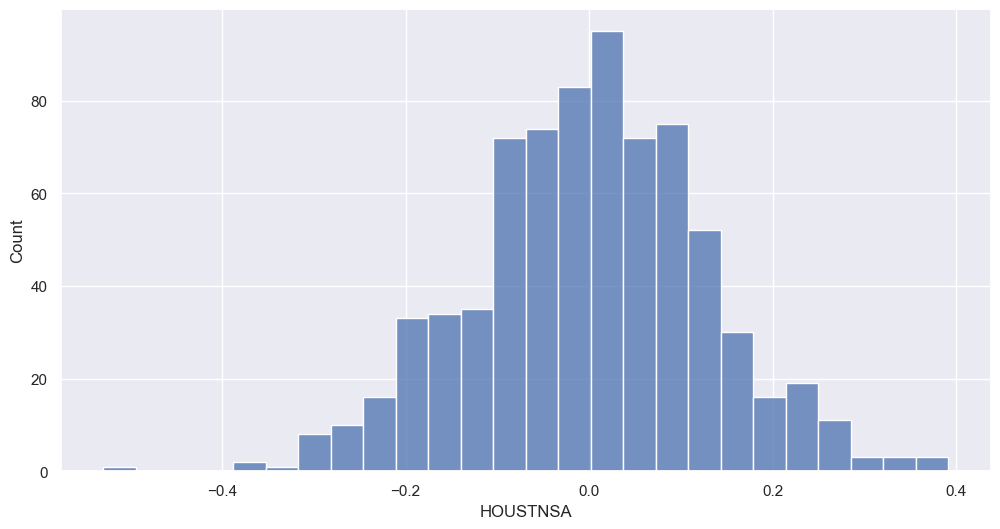

In [11]:
sns.histplot(f_transform.y)
plt.show()

Call a statistical test to ensure its normality:

In [12]:
critical_pval = 0.05
print('-'*100)
k2, p = stats.normaltest(f_transform.y.values)
print("D'Agostino and Pearson's test result for normality:")
print('the test-stat value is: {:.2f}'.format(k2))
print('the p-value is {:.4f}'.format(p))
print('the series is {}'.format('not normal' if p < critical_pval else 'normal'))
print('-'*100)

----------------------------------------------------------------------------------------------------
D'Agostino and Pearson's test result for normality:
the test-stat value is: 4.52
the p-value is 0.1043
the series is normal
----------------------------------------------------------------------------------------------------


Call a statistical test to ensure its stationarity:

In [13]:
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f_transform.adf_test(full_res=True,maxlag=12)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -11.72
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


Now, we can check out its periodogram to make sure no further adjustments are needed to the data:

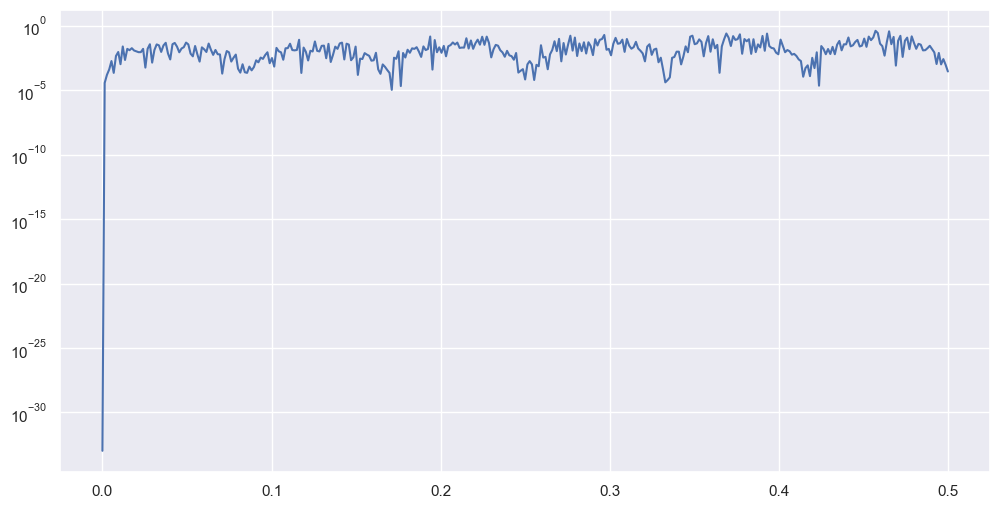

In [14]:
a, b = f_transform.plot_periodogram()
plt.semilogy(a, b)
plt.show()

This shows that there may be some cycles within the data that show stronger effects than other cycles, but for the most part, the periodogram is pretty stable. We can say that the transformations we took work for our purposes.

Now we can call the method and plot the results:

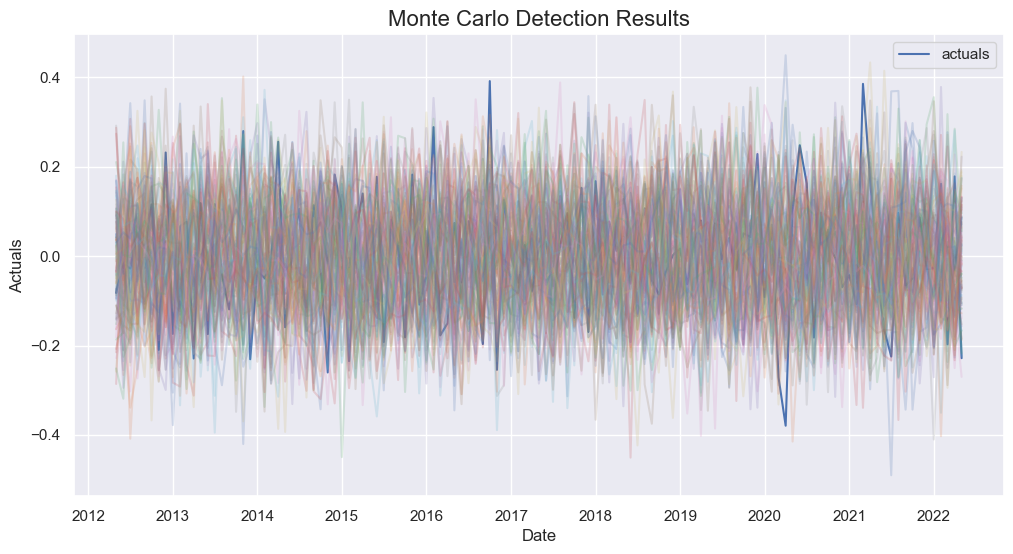

In [15]:
detector2.MonteCarloDetect(
    start_at = '2012-05-01',
    stop_at = '2022-05-01',
    cilevel=.99,
)

detector2.plot_mc_results()
plt.title('Monte Carlo Detection Results',size=16)
plt.show()

The blue line is the series' actual values and the colored lines are the results of each of 100 monte carlo simulations applied on the last 10 years of data available in the set. The few points that clearly stick above or below all colored lines will most likely be labeled as anomalies.

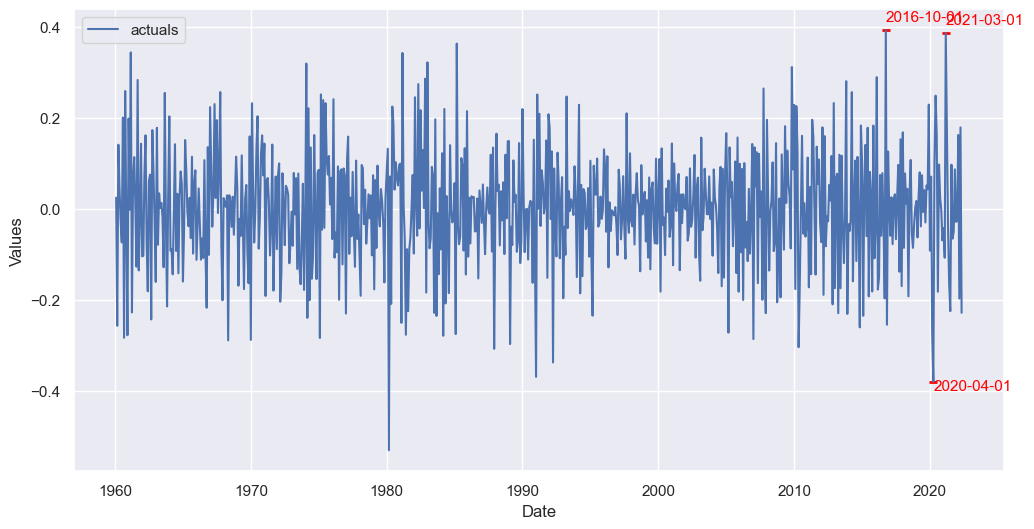

In [16]:
detector2.plot_anom()
plt.show()

We see three points identified:
- Oct. 2016  
- April 2020 (first month of the COVID pandemic)  
- March 2021  

We can plot those points back onto our original series:

In [17]:
_, ax = plt.subplots()

df.iloc[-120:,:].plot(x='DATE',y='HOUSTNSA',ax=ax)

for i,v in zip(detector2.labeled_anom.index,detector2.labeled_anom):
    if v == 1:
        ax.axvline(i,linestyle='--',color='red',alpha=.2)
        ax.text(
            i+pd.Timedelta(days=2),
            60,
            s=i.strftime('%Y-%m-%d'),
            color='red',
            size=10
        )
    
plt.show()

ValueError: Image size of 142208x529 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>

Let's dig into these three points a little more closely.

In [18]:
df2 = df.copy()
df2['year'] = df2.reset_index().DATE.dt.year
df2['month'] = df2.reset_index().DATE.dt.month
df2['pct_chg'] = df2['HOUSTNSA'].pct_change()

In [19]:
avg_chg_month = df2.groupby('month')['pct_chg'].mean().reset_index()
avg_chg_month['pct_chg_std'] = df2.groupby('month')['pct_chg'].std().values
avg_chg_month['pct_chg_2016'] = df2.loc[df2['year'] == 2016,'pct_chg'].values
avg_chg_month['pct_chg_2020'] = df2.loc[df2['year'] == 2020,'pct_chg'].values
avg_chg_month['pct_chg_2021'] = df2.loc[df2['year'] == 2021,'pct_chg'].values

def highlight_rows(row):    

    lightgreen = 'background-color: lightgreen;'
    highlight = 'background-color: lightcoral;'
    default = ''
    
    if row['month'] == 3:
        return [default,lightgreen,lightgreen,default,default,highlight]
    elif row['month'] == 4:
        return [default,lightgreen,lightgreen,default,highlight,default]
    elif row['month'] == 10:
        return [default,lightgreen,lightgreen,highlight,default,default]
    else:
        return [default,lightgreen,lightgreen,default,default,default]

avg_chg_month.style.apply(
    highlight_rows, 
    axis=1
).format(
    {var:'{:.1%}'.format for var in avg_chg_month.iloc[:,1:]}
)

,month,pct_chg,pct_chg_std,pct_chg_2016,pct_chg_2020,pct_chg_2021
0,1,-4.2%,11.9%,-4.9%,4.4%,0.1%
1,2,4.0%,10.9%,13.2%,-1.3%,-11.4%
2,3,32.2%,18.1%,7.8%,-6.4%,37.7%
3,4,13.3%,11.1%,17.1%,-18.8%,-3.6%
4,5,3.9%,8.7%,-1.1%,12.0%,7.5%
5,6,0.6%,8.0%,6.3%,24.9%,5.9%
6,7,-3.4%,7.1%,3.2%,16.8%,-6.7%
7,8,-1.9%,6.9%,-10.8%,-11.7%,-2.7%
8,9,-4.1%,8.2%,-7.6%,3.1%,-3.4%
9,10,2.8%,8.9%,20.5%,3.9%,-1.2%


The reason October 2016 was identified was due to how much more it increased in value from the previous month compared to Octobers from other years. The April 2020 point, as is logical, is from a precipitous decrease in housing starts after the COVID-19 pandemic began. The March 2021 point is the hardest to logically explain, but could be from a large year-over-year increase--a stronger than expected recovery from COVID.

## LSTM Detect

Another technique to identify anomalies includes using an estimator native to scalecast to create bootstrapped confidence intervals around fitted values. All actual values that fall outside of the generated confidence intervals are considered anomalies. This concept is very simple to understand. Let's see how the LSTM model performs in such a process on the same transformed series we used in the Monte Carlo detect.

In [20]:
detector3 = AnomalyDetector(f_transform)

In [21]:
detector3.EstimatorDetect(
    estimator='lstm',
    future_dates=12, # how many forecast steps to train into the lstm? default is 1
    cilevel=.99,
    lags=24,
    epochs=10,
    lstm_layer_sizes=(64,64,64),
    dropout=(0,0,0),
    verbose=0,
)

23/23 [==============================] - 0s 10ms/step


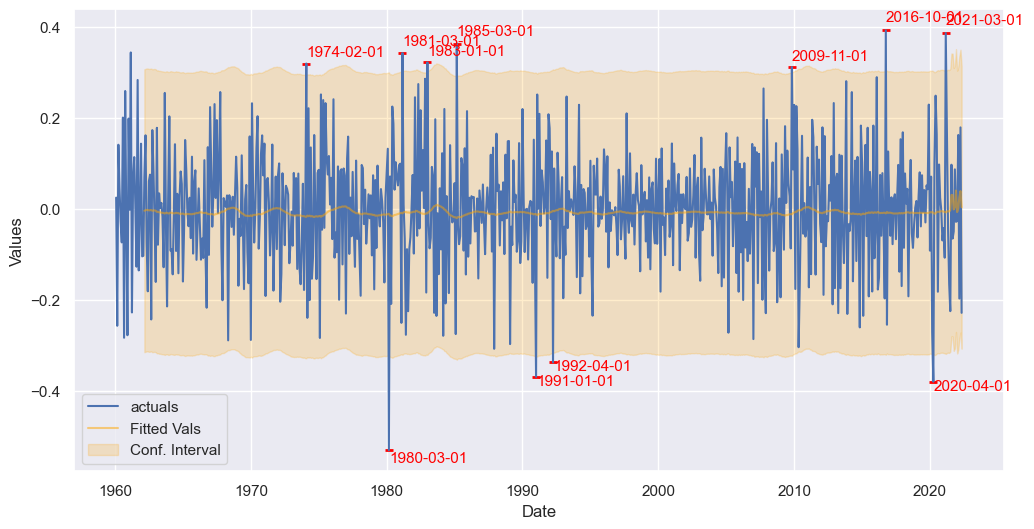

In [22]:
detector3.plot_anom()
plt.show()

The LSTM model does not create a tight fit for this series, but it knows its performance is bad and creates large confidence intervals. As such, we see the same three points identified from the Monte Carlo technique, as well as an additional four points identified from early parts in the series' history. Due to the random nature of this model, results may vary each time it is run.

## ARIMA Detect

Finally, we use the same technique as described above, but change the underlying estimator to ARIMA. We apply the model on the non-transformed series and see the results.

In [23]:
detector4 = AnomalyDetector(f)

In [24]:
detector4.EstimatorDetect(
    estimator='arima',
    cilevel=.99,
    order=(2,1,2),
    seasonal_order=(2,0,0,12),
)

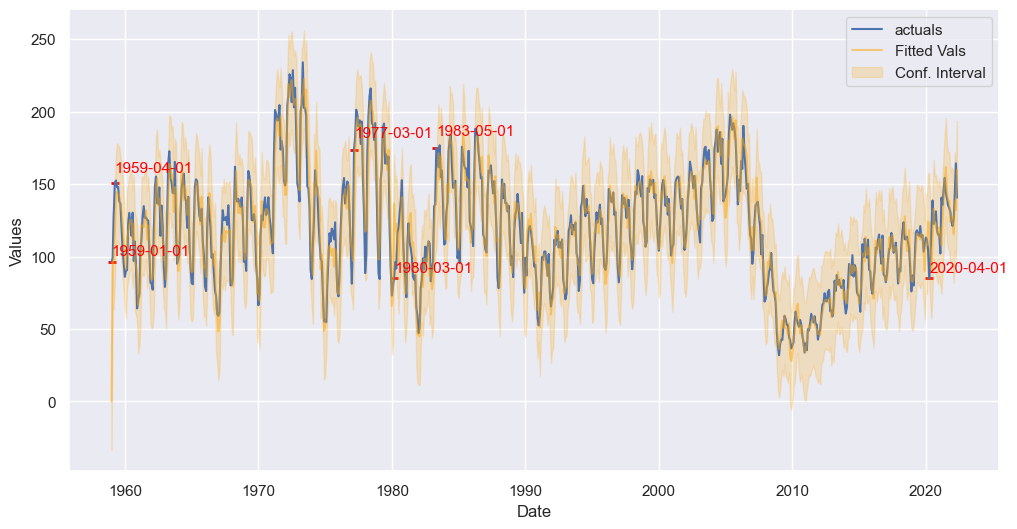

In [25]:
detector4.plot_anom()
plt.show()

The ARIMA model creates a much tighter fit than the LSTM model, but creates tighter confidence intervals as well. According to this method, October 2016 and March 2021 are no longer anomalies, but April 2020 remains. It also identifies several points earlier in the series' history.